https://www.tensorflow.org/tutorials/images/classification

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [25]:
import pathlib
dataset_dir = "assets/normal_dice"
# data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_dir, untar=True)
data_dir = pathlib.Path(dataset_dir)

In [26]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1077


In [27]:
batch_size = 32
img_height = 128
img_width = 128

In [28]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1077 files belonging to 11 classes.
Using 862 files for training.


In [29]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1077 files belonging to 11 classes.
Using 215 files for validation.


In [30]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9']


In [31]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


- Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- Dataset.prefetch overlaps data preprocessing and model execution while training.

In [32]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [33]:
normalization_layer = layers.Rescaling(1./255)

Create the model

In [34]:
import pathlib
dataset_dir = "assets/normal_dice"
# data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_dir, untar=True)
data_dir = pathlib.Path(dataset_dir)

In [35]:
num_classes = 11

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [36]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)       

In [38]:
epochs=3
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/3
27/27 [==============================] - 6s 206ms/step - loss: 1.3944 - accuracy: 0.5684 - val_loss: 0.0618 - val_accuracy: 1.0000
Epoch 2/3
27/27 [==============================] - 5s 199ms/step - loss: 0.0253 - accuracy: 0.9988 - val_loss: 0.0130 - val_accuracy: 1.0000
Epoch 3/3
27/27 [==============================] - 5s 196ms/step - loss: 0.0180 - accuracy: 0.9977 - val_loss: 3.6259e-04 - val_accuracy: 1.0000


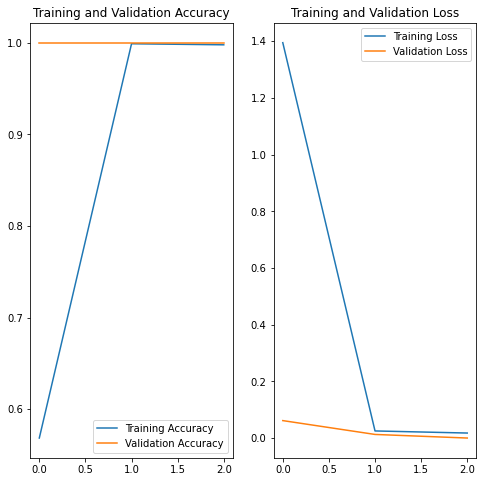

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
image_name = "img_17481_cropped.jpg"
image_path = "assets/anomalous_dice/"

img = tf.keras.utils.load_img(
    image_path + image_name, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 6 with a 97.27 percent confidence.
